# Language Identification

In [2]:
#!pip install sacremoses

## Tokenize data in the proper language


In [3]:
import re

def clean_text(text):
  """ Return the text in lower case, without strange characters and multiples spaces"""
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text


In [4]:
import os
import sys
from sacremoses import MosesTokenizer

def tokenize_files(directory):
    """
    Tokenizes the content of all .txt files in a given directory
    and returns a dictionary where each filename is associated with its list of tokens.
    The file name must be a language.
    """
    tokenized_data = {}

    # Check if the directory exists
    if not os.path.isdir(directory):
        raise FileNotFoundError(f"The directory '{directory}' does not exist.")

    # Iterate over .txt files
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)

            # Determine the language from the filename
            language = filename.replace(".txt", "").lower()
            try:
                tokenizer = MosesTokenizer(lang=language)  # Initialize tokenizer based on language
                with open(file_path, "r", encoding="utf-8") as f:
                    content = clean_text(f.read())
                    tokens = tokenizer.tokenize(content)  # Tokenization
                    tokenized_data[language] = tokens  # Store tokens in dictionary

                print(f"Tokenization completed ({language}): {filename}")
                print(f"Number of tokens in {language}: {len(tokens)} tokens")
                print(f"Size of the data in {language} : {sys.getsizeof(tokens)} bytes")
                print("")
            except Exception as e:
                print(f"Error with {filename} ({language}): {e}")

    return tokenized_data

directory_path = "./data1"
tokenized_results = tokenize_files(directory_path)

Tokenization completed (czech): czech.txt
Number of tokens in czech: 366031 tokens
Size of the data in czech : 2932440 bytes

Tokenization completed (english): english.txt
Number of tokens in english: 402224 tokens
Size of the data in english : 3299032 bytes

Tokenization completed (french): french.txt
Number of tokens in french: 462473 tokens
Size of the data in french : 3711448 bytes



## Split Data
We split the data into the training set, heldout and test sets. We will use 80% of the data for training.
The

In [5]:
def create_sets(tokenized_data):
  """ Create training, held Out and test data set with tokenized_data
  and returns all sets."""

  training_data={}
  test_data={}
  heldout_data={}

  for language, tokens in tokenized_data.items():
      split_training_point=int(len(tokens)*0.8)
      split_test_point=int(len(tokens)*0.1+split_training_point)
      training_data[language]=tokens[:split_training_point]
      test_data[language]=tokens[split_training_point:split_test_point]
      heldout_data[language]=tokens[split_test_point:]

  return training_data,test_data,heldout_data

sets=create_sets(tokenized_results)
training_data=sets[0]
test_data=sets[1]
heldout_data=sets[2]




In [6]:
def calculate_oov_percentage(training_data, data):
    """ Calculate the OOV percentage between the training data and a set of data
    and returns this percentage.
    """
    oov_percentages = {}

    for language in heldout_data:
        training_vocab = set(training_data.get(language))
        tokens = data.get(language)
        
        oov_tokens = [token for token in tokens if token not in training_vocab]
        oov_percentage = (len(oov_tokens) / len(tokens)) * 100 if tokens else 0

        oov_percentages[language] = round(oov_percentage, 2)

    return oov_percentages

print(f"OOV percentage in held out data : {calculate_oov_percentage(training_data, heldout_data)}")
print(f"OOV percentage in test data : {calculate_oov_percentage(training_data, test_data)}")

OOV percentage in held out data : {'czech': 11.84, 'english': 6.32, 'french': 10.88}
OOV percentage in test data : {'czech': 11.35, 'english': 3.92, 'french': 9.14}


## Probabilities of n-grams

First, we create n-grams (characters or tokens).


In [7]:
def extract_charac_ngrams(tokens, n):
  """Extract characters n-grams from a given list of tokens
  and returns a list of n-grams"""
  return [token[i:i+n] for token in tokens for i in range(len(token) - n + 1)]



In [8]:
def extract_tokens_ngrams(tokens, n):
  """Extract tokens n-grams from a given list of tokens
  and returns a list of n-grams"""
  ngrams_list = []
  for i in range(len(tokens) - n + 1):
      ngram = tuple(tokens[i:i + n])
      ngrams_list.append(ngram)

  return ngrams_list


Now, we compute the probabilities and return a dictionary of ``` ngrams ```.


In [9]:
from collections import Counter

def compute_ngram_probabilities(extract_ngrams,tokens, n):
    """
    Compute n-gram probabilities for a given list of tokens
    and returns a dictionary of probabilities, n-gram counts for each and the total number of n-gram.
    """
    ngrams = extract_ngrams(tokens, n)
    ngram_counts = Counter(ngrams)
    total_ngrams = sum(ngram_counts.values())
    if n == 1:

        probabilities = {ngram: count / total_ngrams for ngram, count in ngram_counts.items()}
    else:
        n_minus_1_grams = extract_ngrams(tokens, n - 1)
        n_minus_1_counts = Counter(n_minus_1_grams)
        probabilities = {}
        for ngram, count in ngram_counts.items():
            n_minus_1_ngram = ngram[:-1]
            if n_minus_1_ngram in n_minus_1_counts:
                probabilities[ngram] = count / n_minus_1_counts[n_minus_1_ngram]  # P(w_n | w_{n-2}, w_{n-1})
            else:
                probabilities[ngram] = 0

    return probabilities, ngram_counts, total_ngrams



In [10]:
def get_most_common(ngram_counts, total_ngrams, top_n=5):
    """Return the top 5 most common  n-grams along with their counts and relative frequencies."""
    most_common = [(ngram, count, count / total_ngrams) for ngram, count in ngram_counts.most_common(top_n)]
    return most_common


In [11]:
def get_least_common(ngram_counts, total_ngrams, top_n=5):
    """Return the top 5 least common n-grams along with their counts and relative frequencies."""
    least_common = [(ngram, count, count / total_ngrams) for ngram, count in ngram_counts.most_common()[-top_n:]]
    return least_common


In [12]:
def process_tokenized_data(extract_ngrams,tokenized_data):
    """
    Process tokenized data and compute unigram, bigram, and trigram probabilities
    and returns a dictionary with languages (filenames) as keys and n-gram probabilities, most and least common trigrams as values.
    """
    results = {}

    for language, tokens in tokenized_data.items():
        unigram_probs, unigram_counts, total_unigrams = compute_ngram_probabilities(extract_ngrams,tokens, 1)
        bigram_probs, bigram_counts, total_bigrams = compute_ngram_probabilities(extract_ngrams,tokens, 2)
        trigram_probs, trigram_counts, total_trigrams = compute_ngram_probabilities(extract_ngrams,tokens, 3)

        results[language] = {
            'unigram': unigram_probs,
            'bigram': bigram_probs,
            'trigram': trigram_probs,
            'most_common_trigrams': get_most_common(trigram_counts, total_trigrams),
            'least_common_trigrams': get_least_common(trigram_counts, total_trigrams),
        }

    return results

ngram_charac_results = process_tokenized_data(extract_charac_ngrams, training_data)

ngram_tokens_results = process_tokenized_data(extract_tokens_ngrams, training_data)


In [13]:
for filename, ngrams in ngram_charac_results.items():
    print(f"Data Language: {filename}")
    print(f"Most Common: {ngrams['most_common_trigrams']}")
    print(f"Least Common: {list(ngrams['least_common_trigrams'])}")

Data Language: czech
Most Common: [('ost', 4618, 0.005558497833413578), ('sta', 4555, 0.0054826673086182), ('byl', 4109, 0.004945835339431873), ('jak', 3952, 0.0047568608570052965), ('val', 3813, 0.00458955223880597)]
Least Common: [('sóa', 1, 1.2036591237361579e-06), ('koť', 1, 1.2036591237361579e-06), ('oťá', 1, 1.2036591237361579e-06), ('ťát', 1, 1.2036591237361579e-06), ('yša', 1, 1.2036591237361579e-06)]
Data Language: english
Most Common: [('the', 21738, 0.02821563191177845), ('and', 12975, 0.016841375658079187), ('ing', 9499, 0.012329574364246181), ('her', 9441, 0.012254291143578082), ('hat', 5583, 0.0072466589825862125)]
Least Common: [('ieg', 1, 1.2979865632430974e-06), ('870', 1, 1.2979865632430974e-06), ('shh', 1, 1.2979865632430974e-06), ('zyb', 1, 1.2979865632430974e-06), ('ghh', 1, 1.2979865632430974e-06)]
Data Language: french
Most Common: [('ait', 12546, 0.012786149459141598), ('ent', 11466, 0.011685476621912766), ('que', 11411, 0.011629423838535371), ('ous', 8693, 0.00

In [14]:
for filename, ngrams in ngram_tokens_results.items():
    print(f"Data Language: {filename}")
    print(f"Most Common: {ngrams['most_common_trigrams']}")
    print(f"Least Common: {list(ngrams['least_common_trigrams'])}")
    print("-")

Data Language: czech
Most Common: [(('jako', 'by', 'se'), 67, 0.00022880794475824904), (('že', 'je', 'to'), 53, 0.00018099732943562983), (('se', 's', 'ním'), 50, 0.00017075219758078285), (('pan', 'goljadkin', 'mladší'), 49, 0.0001673371536291672), (('se', 'na', 'něho'), 43, 0.00014684688991947327)]
Least Common: [(('se', 'odvděčím', 'můj'), 1, 3.4150439516156572e-06), (('milý', 'vidíš', 'takové'), 1, 3.4150439516156572e-06), (('vidíš', 'takové', 'to'), 1, 3.4150439516156572e-06), (('to', 'je', 'mnoholi'), 1, 3.4150439516156572e-06), (('je', 'mnoholi', 'ti'), 1, 3.4150439516156572e-06)]
-
Data Language: english
Most Common: [(('i', 'do', 'not'), 85, 0.0002641580970672236), (('there', 'was', 'a'), 79, 0.00024551164315659603), (('one', 'of', 'the'), 76, 0.00023618841620128226), (('i', 'am', 'sure'), 73, 0.00022686518924596848), (('as', 'soon', 'as'), 72, 0.00022375744692753057)]
Least Common: [(('way', 'he', 'does'), 1, 3.1077423184379244e-06), (('he', 'does', 'provoke'), 1, 3.10774231843

## Add less than one smoothing parameter

✅ czech: 239625 unique trigrams
========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

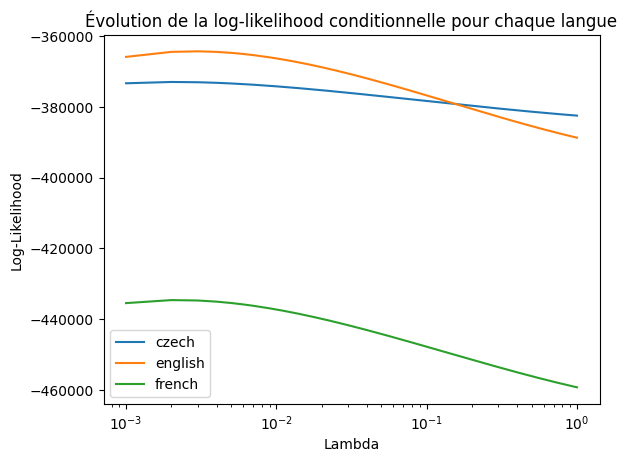

✅ czech: 8754 unique trigrams
==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

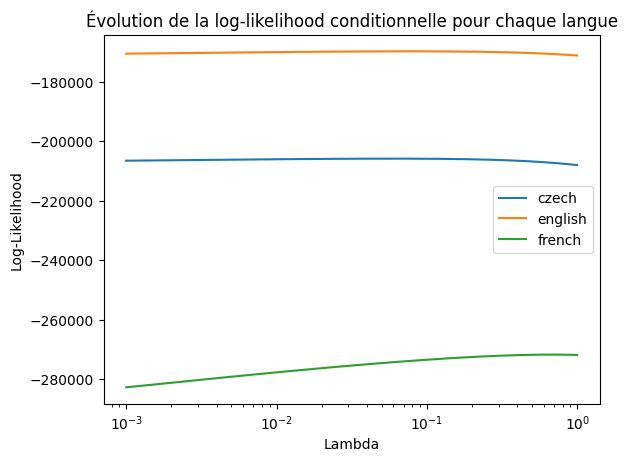

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def estimate_best_smoothing_parameter_conditional(extract_ngrams, training_data, heldout_data, initial_lambda=0.1):
    """
    Estimate the best smoothing parameter using add-less-than-one smoothing,
    with conditional probabilities based on the preceding bigram.
    Returns a dictionary with language as key and best lambda as value.
    """
    smoothing_parameters = {}

    for language in training_data:
        training_trigrams = extract_ngrams(training_data[language], 3)
        heldout_trigrams = extract_ngrams(heldout_data[language], 3)

        # Count trigrams and bigrams in training data
        trigram_counts = Counter(training_trigrams)
        bigram_counts = Counter([trigram[:2] for trigram in training_trigrams])
        vocab = set([trigram[2] for trigram in training_trigrams])
        vocab_size = len(vocab)

        best_lambda = initial_lambda
        best_likelihood = float('-inf')

        print(f"✅ {language}: {len(trigram_counts)} unique trigrams")

        likelihoods = []
        lambda_candidates = []

        for lambda_100 in range(1, 1000, 10):
            print("=", end='')
            lambda_candidate = lambda_100 / 1000
            likelihood = 0

            for trigram in heldout_trigrams:
                bigram = trigram[:2]
                trigram_count = trigram_counts[trigram]
                bigram_count = bigram_counts[bigram]
                
                smoothed_prob = (trigram_count + lambda_candidate) / (bigram_count + lambda_candidate * vocab_size)
                likelihood += np.log(smoothed_prob)

            likelihoods.append(likelihood)
            lambda_candidates.append(lambda_candidate)

            if likelihood > best_likelihood:
                best_likelihood = likelihood
                best_lambda = lambda_candidate

        smoothing_parameters[language] = best_lambda
        print(".")
        plt.plot(lambda_candidates, likelihoods, label=language)

    plt.xlabel("Lambda")
    plt.ylabel("Log-Likelihood")
    plt.title("Évolution de la log-likelihood conditionnelle pour chaque langue")
    plt.legend()
    plt.xscale("log")
    plt.show()

    return smoothing_parameters

lambda_tokens_results = estimate_best_smoothing_parameter_conditional(extract_tokens_ngrams, training_data, heldout_data)
lambda_charac_results = estimate_best_smoothing_parameter_conditional(extract_charac_ngrams, training_data, heldout_data)


In [28]:
print("Best smoothing parameters:")
print(f"Tokens : {lambda_tokens_results}")

print(f"Charac : {lambda_charac_results}")

Best smoothing parameters:
Tokens : {'czech': 0.002, 'english': 0.003, 'french': 0.002}
Charac : {'czech': 0.059, 'english': 0.077, 'french': 0.678}


## Compute Cross Entropy of trigram

In [30]:
def compute_cross_entropy(extract_ngrams, trigrams, best_lambda, language):
    """
    Calcule l'entropie croisée en utilisant le lissage "Add Less Than One".
    
    :param trigrams: Liste des trigrammes extraits du texte à analyser.
    :param train_counts: Dictionnaire des comptes de trigrammes du modèle.
    :param best_lambda: Paramètre de lissage optimisé.
    :param V: Nombre total de trigrammes uniques (vocabulaire).
    :return: L'entropie croisée du texte pour cette langue.
    """
    H = len(trigrams)
    
    training_trigrams = extract_ngrams(training_data[language], 3)
    trigram_counts = Counter(training_trigrams)
    bigram_counts = Counter([trigram[:2] for trigram in training_trigrams])

    vocab = set([trigram[2] for trigram in training_trigrams])
    vocab_size = len(vocab)

    entropy = 0
    for trigram in trigrams:
        bigram = trigram[:2]
        trigram_count = trigram_counts.get(trigram, 0)
        bigram_count = bigram_counts.get(bigram, 0)

        smoothed_prob = (trigram_count + best_lambda) / (bigram_count + best_lambda * vocab_size)

        entropy -= np.log2(smoothed_prob)


    return entropy / H


In [31]:
cross_entropies = {}

for language_train in training_data.keys():
  best_lambda = lambda_tokens_results.get(language_train, 0.002)
  for language, test_tokens in test_data.items():
      trigrams = extract_tokens_ngrams(test_tokens, 3)
      cross_entropies[language,language_train] =compute_cross_entropy(extract_tokens_ngrams,trigrams, best_lambda, language_train)

for languages in cross_entropies.keys():
    print(f"Language Training : {languages[1]}, Language test : {languages[0]}\n Proba Cross-Entropy :{cross_entropies.get(languages)}")
    print("\n")

cross_entropies = {}
for language_train in training_data.keys():
  best_lambda = lambda_charac_results.get(language_train, 0.002)
  for language, test_tokens in test_data.items():
      trigrams = extract_charac_ngrams(test_tokens, 3)
      cross_entropies[language,language_train] =compute_cross_entropy(extract_charac_ngrams,trigrams, best_lambda, language_train)

for languages in cross_entropies.keys():
    print(f"Language Training : {languages[1]}, Language test : {languages[0]}\n Proba Cross-Entropy :{cross_entropies.get(languages)}")
    print("\n")

Language Training : czech, Language test : czech
 Proba Cross-Entropy :14.635537035912408


Language Training : czech, Language test : english
 Proba Cross-Entropy :15.189849267005622


Language Training : czech, Language test : french
 Proba Cross-Entropy :15.189396309814004


Language Training : english, Language test : czech
 Proba Cross-Entropy :14.265628605631235


Language Training : english, Language test : english
 Proba Cross-Entropy :12.876128038138


Language Training : english, Language test : french
 Proba Cross-Entropy :14.22896923301166


Language Training : french, Language test : czech
 Proba Cross-Entropy :14.612273957119559


Language Training : french, Language test : english
 Proba Cross-Entropy :14.61167739632073


Language Training : french, Language test : french
 Proba Cross-Entropy :13.335826385921626


Language Training : czech, Language test : czech
 Proba Cross-Entropy :2.9399140359993905


Language Training : czech, Language test : english
 Proba Cross-Ent

With that output, we can see that is less important when it is the good language, we will use this for the implementation of ``identify_language()``

## Identify Language

In [32]:
def softmax(scores):
    """Transform scores into probabilities"""
    exp_scores = np.exp(-np.array(list(scores.values())))  # e^(-H)
    sum_exp_scores = np.sum(exp_scores)
    probabilities = {lang: exp_scores[i] / sum_exp_scores for i, lang in enumerate(scores)}
    return probabilities

In [33]:
def identify_tokens_language(text_):
    """Identifies the language of a given text by comparing tokens trigram probabilities
    and returns a sorted list with the language and probabilities the most probable to the least"""

    tokenizer = MosesTokenizer(lang='en')  # Default to English tokenizer
    tokens_text = tokenizer.tokenize(text_)

    if len(tokens_text) < 3 :
        print("Text too short, please send at least 3 words")
        return None

    trigrams_text = extract_tokens_ngrams(tokens_text, 3)

    language_scores = {}

    for language in training_data.keys():
        language_scores[language] = compute_cross_entropy(extract_tokens_ngrams,trigrams_text, lambda_tokens_results.get(language, 0.002),language)
    
    
    language_probabilities = softmax(language_scores)
    sorted_languages = sorted(language_probabilities.items(), key=lambda x: x[1],reverse=True)



    return sorted_languages


def identify_charac_language(text_):
    """Identifies the language of a given text by comparing characters trigram probabilities
     and returns a sorted list with the language and probabilities the most probable to the least"""

    tokenizer = MosesTokenizer(lang='en')  # Default to English tokenizer
    tokens_text = tokenizer.tokenize(text_)

    if len(tokens_text) < 3 :
        print("Text too short, please send at least 3 words")
        return None

    trigrams_text = extract_charac_ngrams(tokens_text, 3)

    language_scores = {}

    for language in training_data.keys():
        language_scores[language] = compute_cross_entropy(extract_charac_ngrams,trigrams_text, lambda_charac_results.get(language, 0.002),language)
    
    
    language_probabilities = softmax(language_scores)
    sorted_languages = sorted(language_probabilities.items(), key=lambda x: x[1],reverse=True)



    return sorted_languages





Neither of comparing using characters and tokens probabilities is very efficient, but using both reduce wrong return.

In [34]:
def identify_language(text_):
    """ Identifies the language of a given text by comparing trigram of characters and tokens probabilities
     and returns a sorted list with the language and probabilities the most probable to the least"""
    tokens_prob = identify_tokens_language(text_)
    charac_prob = identify_charac_language(text_)
    if charac_prob[0][1] > tokens_prob[0][1] :
        return charac_prob
    return tokens_prob

In [35]:

text = "je susi ravie de te rencontrer  "
print(f"Both trigrams : {identify_language(text)}")
print("\n")
print(f"Tokens : {identify_tokens_language(text)}")
print(f"Charac : {identify_charac_language(text)}")

Both trigrams : [('french', np.float64(0.6770639028384634)), ('english', np.float64(0.29670909474906093)), ('czech', np.float64(0.02622700241247566))]


Tokens : [('english', np.float64(0.4797180883356312)), ('french', np.float64(0.3298405222431865)), ('czech', np.float64(0.19044138942118238))]
Charac : [('french', np.float64(0.6770639028384634)), ('english', np.float64(0.29670909474906093)), ('czech', np.float64(0.02622700241247566))]


In [36]:
print("----- Test for Czech Language -----")
text1 = "Jsem test a pracuji"
print(f"Test text : {text1}")
print("\n")
print(f"Both trigrams : {identify_language(text1)}")
print("\n")
print(f"Tokens : {identify_tokens_language(text1)}")
print(f"Charac : {identify_charac_language(text1)}")
print("\n")


----- Test for Czech Language -----
Test text : Jsem test a pracuji


Both trigrams : [('czech', np.float64(0.8456819854875095)), ('french', np.float64(0.09487340677909646)), ('english', np.float64(0.059444607733393925))]


Tokens : [('english', np.float64(0.4753134023023119)), ('french', np.float64(0.33599380719021305)), ('czech', np.float64(0.18869279050747514))]
Charac : [('czech', np.float64(0.8456819854875095)), ('french', np.float64(0.09487340677909646)), ('english', np.float64(0.059444607733393925))]




In [37]:


print("----- Test for English Language -----")
text = "I am a test and I am working"
print(f"Test text : {text}")
print("\n")
print(f"Both trigrams : {identify_language(text)}")
print("\n")
print(f"Tokens : {identify_tokens_language(text)}")
print(f"Charac : {identify_charac_language(text)}")
print("\n")



----- Test for English Language -----
Test text : I am a test and I am working


Both trigrams : [('english', np.float64(0.8449580257650083)), ('french', np.float64(0.09943845625737475)), ('czech', np.float64(0.055603517977616895))]


Tokens : [('english', np.float64(0.4650866694535091)), ('french', np.float64(0.3425427049895165)), ('czech', np.float64(0.19237062555697432))]
Charac : [('english', np.float64(0.8449580257650083)), ('french', np.float64(0.09943845625737475)), ('czech', np.float64(0.055603517977616895))]




In [38]:
print("----- Test for French Language -----")
text = "Je suis un test et je fonctionne"
print(f"Test text : {text}")
print("\n")
print(f"Both trigrams : {identify_language(text)}")
print("\n")
print(f"Tokens : {identify_tokens_language(text)}")
print(f"Charac : {identify_charac_language(text)}")
print("------------------------------------")

----- Test for French Language -----
Test text : Je suis un test et je fonctionne


Both trigrams : [('french', np.float64(0.7507502659744881)), ('english', np.float64(0.23521567307768718)), ('czech', np.float64(0.014034060947824634))]


Tokens : [('english', np.float64(0.5594732272509916)), ('czech', np.float64(0.2242468081819785)), ('french', np.float64(0.2162799645670299))]
Charac : [('french', np.float64(0.7507502659744881)), ('english', np.float64(0.23521567307768718)), ('czech', np.float64(0.014034060947824634))]
------------------------------------
